In [2]:
 #Import All Libraries Here
import pandas as pd
from sklearn.metrics import accuracy_score ,  roc_curve, auc , classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np

import gensim
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split , RandomizedSearchCV
import xgboost as xgb 
import statistics
from scipy.fftpack import fft, ifft


from imblearn.over_sampling import SMOTE 
from imblearn.over_sampling import RandomOverSampler

from igraph import *

from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier


In [3]:
# Record Constants
INPUT_TRAIN_IN = "../../data/train_in.csv"
INPUT_TRAIN_OUT = "../../data/train_out.csv"  
INPUT_TEST_IN = "../../data/test_in.csv"
INPUT_TEST_OUT = "../../data/test_out.csv"

INPUT_VALIDATION_IN = "../../data/valid_in_nucleo.csv"
INPUT_VALIDATION_OUT  = "../../data/valid_out.csv"

TARGET_MODEL_PATH = '../../webapp/model_files'

WINDOW_SIZE =  50 # Final RNA Sequence will be 101 Length 
MAX_LENGTH = (WINDOW_SIZE*2) +1
ENCODING_METHOD = 2 # 1 - ANF Encoding , 2 - One Hot Encoding  , 3 - Complex Network  , 4 - Word2Vec Model , 5 - K-mer with One Hot , 6 - Multi RM Encoding
PERFORM_DATA_BALANCING = False
K_MERS_SIZE = 3

In [4]:
#Read X Varaibles and Y Varaibles

x_train_raw =  pd.read_csv(INPUT_TRAIN_IN, header=None , skiprows=1 )
y_train_raw =  pd.read_csv(INPUT_TRAIN_OUT, header=None , skiprows=1 )

x_test_raw =  pd.read_csv(INPUT_TEST_IN, header=None , skiprows=1)
y_test_raw =  pd.read_csv(INPUT_TEST_OUT, header=None , skiprows=1)

x_valid_raw =  pd.read_csv(INPUT_VALIDATION_IN, header=None , skiprows=1)
y_valid_raw =  pd.read_csv(INPUT_VALIDATION_OUT, header=None , skiprows=1)

x_data = pd.concat([x_train_raw, x_test_raw, x_valid_raw], axis=0, ignore_index=True)
y_data = pd.concat([y_train_raw, y_test_raw, y_valid_raw], axis=0, ignore_index=True)


print("Shape of Input Feature - " , x_data.shape)

Shape of Input Feature -  (309460, 1001)


### Calculate Sequence Positions to extracted from Original Sequence 

In [5]:
middle_index = (x_train_raw.shape[1] // 2) + 1
STRAT_INEDX =middle_index - WINDOW_SIZE -1 
END_INDEX =middle_index + WINDOW_SIZE 

# x_data =x_data.iloc[:100]
# x_data.head()

# y_data =y_data.iloc[:100]
# y_data.shape

### Apply Graph - Complex Network

In [6]:
def feature_extraction_graph(thresholdCN):
    metrics = []
    metrics.append(mean(thresholdCN.betweenness(directed=False, weights=None)))
    metrics.append(mean(thresholdCN.degree()))
    metrics.append(thresholdCN.assortativity_degree(directed=False))  # Returns the assortativity
    metrics.append(max(thresholdCN.degree()))
    metrics.append(min(thresholdCN.degree()))
    metrics.append(np.std(thresholdCN.degree()))  # Returns the strength (weighted degree)
    metrics.append(thresholdCN.average_path_length(directed=False, unconn=False))  # Average path length
    metrics.append(thresholdCN.transitivity_avglocal_undirected())  # local transitivity (clustering coefficient)
    metrics.append(thresholdCN.transitivity_undirected())  # global transitivity (clustering coefficient)
    metrics.append(cn.ecount())  # Counts the number of edges
    metrics.append(thresholdCN.motifs_randesu_no(size=3))
    metrics.append(thresholdCN.motifs_randesu_no(size=4))
    metrics.append(mean(thresholdCN.authority_score()))
    metrics.append(mean(thresholdCN.closeness(vertices=None, mode=ALL, cutoff=None, weights=None, normalized=True)))  # Calculates the closeness centralities of given vertices in a graph
    metrics.append(mean(thresholdCN.constraint(vertices=None, weights=None)))  # Calculates Burt's constraint scores for given vertices in a graph.
    metrics.append(mean(thresholdCN.count_multiple(edges=None)))  # Counts the multiplicities of the given edges.
    metrics.append(thresholdCN.density(loops=False))  # Calculates the density of the graph.
    metrics.append(thresholdCN.diameter(directed=False, unconn=False, weights=None))  # Calculates the diameter of the graph.
    metrics.append(mean(thresholdCN.eccentricity(vertices=None, mode=ALL)))  # Calculates the eccentricities of given vertices in a graph.
    metrics.append(mean(thresholdCN.edge_betweenness(directed=False, cutoff=None, weights=None)))  # Calculates or estimates the edge betweennesses in a graph.
    metrics.append(mean(thresholdCN.hub_score()))  # Calculates Kleinberg's hub score for the vertices of the graph.
    metrics.append(thresholdCN.maxdegree())  # Returns the maximum degree of a vertex set in the graph.
    metrics.append(mean(thresholdCN.neighborhood_size()))  # For each vertex specified by vertices, returns the number of vertices reachable from that vertex in at most order steps
    metrics.append(thresholdCN.radius())  # Calculates the radius of the graph.
    metrics.append(mean(thresholdCN.strength()))  # Returns the strength (weighted degree) of some vertices from the graph.
    metrics.append(cn.vcount())  # Counts the number of vertices.

    return metrics

def patterns(seq, win):
    """
    Generate k-mers: subsequences of length k
    contained in a biological sequence.
    """
    seqlen = len(seq)
    for i in range(seqlen):
        j = seqlen if i + win > seqlen else i + win
        yield seq[i:j]
        if j == seqlen: break
    return

def complex_network(seq):
    """Generates complex network"""
    global name_seq, cn
    ksize = K_MERS_SIZE
    threshold = 3

    metrics = []
    cn = Graph()
    seq = seq.upper()
    
    for k in range(1, ksize + 1):
        cn = Graph()
        kmer = []
        for subseq in patterns(seq, k):  # Generates k pattern
            kmer.append(str(subseq))
        #print(kmer)
        vertices = np.unique(kmer)
        for vert in vertices:
            cn.add_vertices(vert)
        for i in range(len(kmer)-1):  # Position -1 -- Build the Network
            cn.add_edges([(kmer[i], kmer[i+1])])
        # print(summary(cn))
        metrics +=feature_extraction_graph(cn)
        #print('Result Matric' , metrics)
        #print('Size of Matric with k ' , k , '  Size ' , len(metrics))
    metrics_preprocessing = np.nan_to_num(metrics)     
    return metrics_preprocessing

def encode_using_graph(x_train_raw):
    truncated_df = x_train_raw.iloc[:,STRAT_INEDX :END_INDEX]
    truncated_df['Sequence'] = truncated_df.apply(lambda row: ''.join(map(str, row)), axis=1)
    result = truncated_df['Sequence'].apply(complex_network)
    return result 



### Apply ANF Encoding 

In [7]:
# Apply ANF Encoding on Input Features
def apply_accumulated_nucle_frequency(seq):
    mapping = []
    A = 0
    C = 0
    T = 0
    G = 0
    for i, v in seq.items():
        if v == 'A':
            A += 1
            mapping.append(A / (i + 1))
        elif v == 'C':
            C += 1
            mapping.append(C / (i + 1))
        elif v == 'T' or v == 'U':
            T += 1
            mapping.append(T / (i + 1))
        else:
            G += 1
            mapping.append(G / (i + 1))
    padding = (MAX_LENGTH - len(mapping))
    mapping = np.pad(mapping, (0, padding), 'constant')
    return mapping

# # Encode X Features Based on Middle Index
def encode_using_anf(x_train_raw):
    truncated_df = x_train_raw.iloc[:,STRAT_INEDX :END_INDEX]
    print(truncated_df.shape)
    result = truncated_df.apply(apply_accumulated_nucle_frequency, axis=1)
    return result 

### Apply One Hot Encoding

In [8]:
# Create One Hot Encoding for RNA Sequence 
def one_hot_encode_sequence(seq):
    bases = 'ACGT'
    base_dict = {base: i for i, base in enumerate(bases)}
    one_hot = np.zeros((len(seq), len(bases)))
    for i, base in enumerate(seq):
        if base == 'N':
            continue
        one_hot[i, base_dict[base]] = 1
    return one_hot.flatten()


# Encode X Features Based on Middle Index
def encode_x_with_in_hot(x_train_raw):
    truncated_df =  x_train_raw.iloc[:,STRAT_INEDX :END_INDEX] # Window Starts from V501 with 50 window size
    truncated_df['Sequence'] = truncated_df.apply(lambda row: ''.join(map(str, row)), axis=1)
    print(truncated_df)
    result =  truncated_df['Sequence'].apply(one_hot_encode_sequence)
    return result 



### Apply Word2Vec Model

In [9]:
# Model Documentation - 
# Encode RNA sequences using Word2Vec embeddings
def encode_sequence(sequence , word2vec_model):
    embeddings = []
    for kmer in sequence:
        embeddings.append(word2vec_model.wv[kmer])
    return np.mean(embeddings, axis=0)

def applyKmersAndEncoding(seq):
    k = 3
    tokenized_sequences = [''.join(seq[i:i+k]) for i in range(0, len(seq)-k+1)]
    return tokenized_sequences
    


def encode_x_with_word2Vec(x_train_raw):
    truncated_df =  x_train_raw.iloc[:,STRAT_INEDX :END_INDEX] # Window Starts from V501 with 50 window size
    truncated_df['Sequence'] = truncated_df.apply(lambda row: ''.join(map(str, row)), axis=1)
    tokenized_sequences =  truncated_df['Sequence'].apply(applyKmersAndEncoding).tolist()
    
    # The result, tokenized_sequences, is a list of lists, where each inner list
    #  contains the k-mers of the corresponding RNA sequence from the truncated_df list. 
    embedding_size = 100
    word2vec_model = gensim.models.Word2Vec(tokenized_sequences, vector_size=embedding_size, window=5, min_count=1, workers=4)

    result = []
    for seq in tokenized_sequences:
        embedding = encode_sequence(seq , word2vec_model)
        result.append(embedding)
    return result 


### Apply One Hot with K mers

In [10]:
def applyOneHotEncoding(tokenized_sequences):
    encoded_sequences = []
    for seq in tokenized_sequences:
        encoded_sequences.append(one_hot_encode_sequence(seq))    
    # print("Encoded Sequence ")
    # print(encoded_sequences)
    return np.array(encoded_sequences).flatten()

def applyKmersAndEncoding(seq):
    k=3
    tokens = [seq[i:i+k] for i in range(0, len(seq)-k+1)]
    return tokens
    

def encode_x_with_k_mer_one_hot_encoding(x_train_raw):
    truncated_df =  x_train_raw.iloc[:,STRAT_INEDX :END_INDEX] # Window Starts from V501 with 50 window size
    truncated_df['Sequence'] = truncated_df.apply(lambda row: ''.join(map(str, row)), axis=1)
    tokenized_sequences =  truncated_df['Sequence'].apply(applyKmersAndEncoding).tolist()
    
    # The result, tokenized_sequences, is a list of lists, where each inner list
    #  contains the k-mers of the corresponding RNA sequence from the truncated_df list. 
   

    result = []
    for seq in tokenized_sequences:
        embedding = applyOneHotEncoding(seq)
        # print("Final")
        # print(embedding)
        result.append(embedding)
    return result 

### Apply Multi RM K-mers Embedding 

In [11]:
import pickle
model = pickle.load(open("C:/Users/shashi.vish/Documents/Shashi/Education/HigherEducation/NUS/Capstone Project/Git\MultiRM/Embeddings/embeddings_12RM.pkl", 'rb'))

def applyMultiRmEncoding(tokenized_sequences):
    embeddings = []
    for kmer in tokenized_sequences:
        embeddings.append(model[kmer])
    return np.mean(embeddings, axis=0)

def applyKmersAndEncoding(seq):
    k=3
    tokens = [seq[i:i+k] for i in range(0, len(seq)-k+1)]
    return tokens
    

def encode_x_with_k_mer_multi_rm(x_train_raw):
    truncated_df =  x_train_raw.iloc[:,STRAT_INEDX :END_INDEX] # Window Starts from V501 with 50 window size
    truncated_df['Sequence'] = truncated_df.apply(lambda row: ''.join(map(str, row)), axis=1)
    tokenized_sequences =  truncated_df['Sequence'].apply(applyKmersAndEncoding).tolist()

    result = []
    for seq in tokenized_sequences:
        embedding = applyMultiRmEncoding(seq)
        result.append(embedding)
    return result 


### Apply Embedding Encoding From Multi RM Team

### Perform Encoding of X Features

In [12]:
# Apply Encoding Method
if ENCODING_METHOD == 1:
    x_encoded = encode_using_anf(x_data).tolist()
if ENCODING_METHOD == 3:
    x_encoded = encode_using_graph(x_data).tolist()
if ENCODING_METHOD == 2:
    x_train = pd.DataFrame()
    x_train['one_hot_encoded'] = encode_x_with_in_hot(x_data)
    x_encoded = np.array(x_train['one_hot_encoded'].tolist())
if ENCODING_METHOD == 4:
     x_encoded = encode_x_with_word2Vec(x_data)
if ENCODING_METHOD == 5:
     x_encoded = encode_x_with_k_mer_one_hot_encoding(x_data)     

if ENCODING_METHOD == 6:
     x_encoded = encode_x_with_k_mer_multi_rm(x_data)   
  

C:\Users\shashi.vish\AppData\Local\Temp\ipykernel_14220\2995210075.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  truncated_df['Sequence'] = truncated_df.apply(lambda row: ''.join(map(str, row)), axis=1)


       450 451 452 453 454 455 456 457 458 459  ... 542 543 544 545 546 547  \
0        T   T   G   C   C   A   C   A   C   T  ...   C   A   G   T   A   T   
1        T   T   T   G   A   A   A   A   A   A  ...   T   C   A   T   C   G   
2        A   G   A   A   A   C   A   T   T   C  ...   T   T   C   T   G   T   
3        T   T   A   G   T   T   T   T   A   C  ...   A   A   A   A   A   T   
4        C   A   A   C   A   G   A   A   G   T  ...   A   A   A   A   T   G   
...     ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..   
309455   C   C   A   A   A   C   T   C   T   T  ...   G   G   G   C   A   G   
309456   G   A   T   C   C   A   G   T   T   G  ...   A   C   A   G   G   T   
309457   G   C   C   A   G   G   G   C   A   A  ...   C   A   A   G   C   T   
309458   C   T   G   G   G   T   G   C   G   A  ...   G   C   A   G   A   G   
309459   G   G   C   T   G   C   T   A   A   G  ...   C   T   C   A   A   A   

       548 549 550                                 

In [13]:
# Persist Feature to a File.
# import csv
# with open('Complext_Network_Feature.csv', 'w', newline='') as csvfile:
#     writer = csv.writer(csvfile , delimiter = ',')
#     for row in x_encoded:
#         writer.writerow(row)

### Encode Each Y category to 0 to 12 classes.

In [13]:
#Decode Y to its Original Form . Additional Class - NonMoD added for Non Modified RNA Sequence 
RMs = ['hAm','hCm','hGm','hTm','hm1A','hm5C','hm5U','hm6A','hm6Am','hm7G','hPsi','Atol','NonMoD']
RMEncoding = [12,1,2,3,4,5,6,7,8,9,10,11,0]

def decode_y(row):   
    decoded = ''
    for index , n in enumerate(row.tolist()) :
        if n == 1 :
            decoded = RMEncoding[index]
    
    if decoded == '':
        return 0
    
    return decoded 

#y_encoded =  y_train_raw.apply(decode_y , axis=1)
#y_test_encoded = y_test_raw.apply(decode_y,axis =1)

y_encoded = y_data.apply(decode_y,axis=1)

y_encoded.value_counts()

0     154607
7      65178
11     52618
4      16341
6       3696
5       3207
10      3137
8       2447
3       2253
1       1878
12      1591
2       1471
9       1036
dtype: int64

In [15]:
#Code Reference : https://github.com/dmlc/xgboost/blob/master/demo/multiclass_classification/train.py

# PERFORM_DATA_BALANCING - if True then code will perform over sampling for each category.


### Split Data into Train and Test

In [14]:

# Train set
X_train, X_temp, y_train, y_temp = train_test_split(x_encoded, y_encoded, test_size=0.3, random_state=42)

# Test and Validation set
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


y_train.value_counts()

0     108371
7      45594
11     36767
4      11444
6       2589
5       2239
10      2206
8       1665
3       1592
1       1286
12      1108
2       1043
9        718
dtype: int64

### Re-Sample Data Using RandomOverSampler

In [17]:
if PERFORM_DATA_BALANCING:
    sm = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = sm.fit_resample(X_train, y_train)
    print(y_resampled.value_counts())
    

### Train using XGBoost 

In [18]:

# Define XGBoost parameters
params = {
    'objective': 'multi:softmax',
    'num_class': 13,
    'max_depth': 4,
    'n_jobs': -1,
    'enable_categorical': True
}


if PERFORM_DATA_BALANCING:
    dtrain = xgb.DMatrix(X_resampled, label=y_resampled)
    num_rounds = 100    
    model = xgb.train(params, dtrain, num_rounds)     
else:
    dtrain = xgb.DMatrix(X_train, label=y_train)
    num_rounds = 100    
    model = xgb.train(params, dtrain, num_rounds) 




[11:04:30] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "enable_categorical" } are not used.



### Calculate Test Accuracy

In [19]:
dtest = xgb.DMatrix(X_test)
y_pred = model.predict(dtest) 
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.63


### Calculate Validation Accuracy

In [20]:
dvalid = xgb.DMatrix(X_valid)
# Make predictions on test set
y_pred_val = model.predict(dvalid) 
accuracy = accuracy_score(y_valid, y_pred_val)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.63


Accuracy of XGBoost  model: 0.63


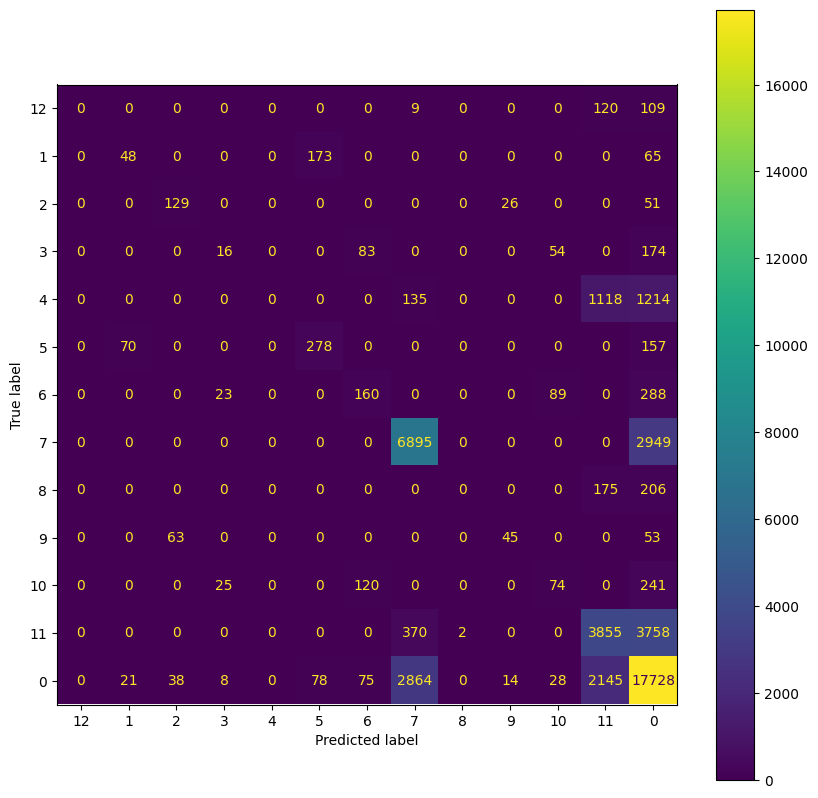

In [21]:
# Plot confusion matrix 
cm = confusion_matrix(y_test, y_pred, labels=np.array(RMEncoding))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=np.array(RMEncoding))

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)

print("Accuracy of XGBoost  model: {:.2f}".format(accuracy))

### XgBoost with Hyper Paramter Tuning - RandomizedSearchCV

In [22]:
# Create the XGBoost classifier
xgb_clf = xgb.XGBClassifier(objective='multi:softmax', num_class=13, random_state=42)

# Define the hyperparameter search space
param_dist = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7, 10],
    'min_child_weight':   [1, 3, 5],
    'subsample': [0.5, 0.75, 1],
    'colsample_bytree': [0.5, 0.75, 1],
    'n_estimators': [100, 250, 500]
}

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(xgb_clf, param_dist, cv=3, n_iter=20, scoring='accuracy', verbose=1, n_jobs=-1, random_state=42)

# Perform the randomized search
random_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_
print("Best hyperparameters:\n", best_params)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [ ]:
# Train the classifier with the best hyperparameters
best_xgb_clf = xgb.XGBClassifier(**best_params, objective='multi:softmax', num_class=13, random_state=42)
best_xgb_clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_xgb_clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7324324324324324

Classification report:
               precision    recall  f1-score   support

           0       0.78      0.79      0.79      1026
           1       0.75      0.82      0.78       294
           2       0.77      0.86      0.81       222
           3       0.71      0.90      0.80       245
           4       0.00      0.00      0.00        35
           5       0.00      0.00      0.00        32
           6       0.00      0.00      0.00        20
           7       0.53      0.40      0.45        25
           8       0.20      0.05      0.08        19
           9       0.00      0.00      0.00        19
          10       0.00      0.00      0.00        26
          11       0.00      0.00      0.00        27
          12       0.56      0.65      0.60       230

    accuracy                           0.73      2220
   macro avg       0.33      0.34      0.33      2220
weighted avg       0.68      0.73      0.70      2220



c:\Users\shashi.vish\Documents\Python Environment\RNA_ModX\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\shashi.vish\Documents\Python Environment\RNA_ModX\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\shashi.vish\Documents\Python Environment\RNA_ModX\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

### XgBoost with Hyper Paramter Tuning - GridSearchCV

In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Create the XGBoost classifier
xgb_clf = xgb.XGBClassifier(objective='multi:softmax', num_class=13, random_state=42 )

# Define the hyperparameter search space
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7, 10],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.5, 0.75, 1],
    'colsample_bytree': [0.5, 0.75, 1],
    'n_estimators': [100, 250, 500]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(xgb_clf, param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:\n", best_params)

# Train the classifier with the best hyperparameters
best_xgb_clf = xgb.XGBClassifier(**best_params, objective='multi:softmax', num_class=13, random_state=42)
best_xgb_clf.fit(X_train, y_train)

NameError: name 'xgb' is not defined

In [ ]:
# Make predictions on the test set
y_pred = best_xgb_clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))

### Random Forest Classifier 

In [18]:
# Train the Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [19]:
# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6015855576380361

Classification report:
               precision    recall  f1-score   support

           0       0.58      0.88      0.70     22999
           1       0.20      0.01      0.01       286
           2       0.88      0.03      0.07       206
           3       0.40      0.01      0.01       327
           4       0.23      0.00      0.01      2467
           5       0.51      0.07      0.12       505
           6       0.39      0.03      0.05       560
           7       0.70      0.58      0.63      9844
           8       0.00      0.00      0.00       381
           9       1.00      0.01      0.01       161
          10       0.20      0.01      0.01       460
          11       0.56      0.24      0.34      7985
          12       0.00      0.00      0.00       238

    accuracy                           0.60     46419
   macro avg       0.43      0.14      0.15     46419
weighted avg       0.57      0.60      0.54     46419



c:\Users\shashi.vish\Documents\Python Environment\RNA_ModX\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\shashi.vish\Documents\Python Environment\RNA_ModX\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\shashi.vish\Documents\Python Environment\RNA_ModX\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

## Save Model 

In [ ]:
# import pickle

# TARGET_MODEL_PATH += '/xgboost_model.bin'

# ##dump the model into a file
# with open(TARGET_MODEL_PATH, 'wb') as f_out:
#     pickle.dump(bst, f_out) # write final_model in .bin file
#     f_out.close()  # close the file 
#     print("Exported Model Successfully")  

### Multiple Model Excution

#  ---------------------- Further Feature Extraction with ANF Fourier Transform -----------------------------------

In [ ]:
# def feature_extraction(features, spectrum, spectrumTwo):
#     average = sum(spectrum) / len(spectrum)
#     features.append(average)
#     ###################################
#     median = np.median(spectrum)
#     features.append(median)
#     ###################################
#     maximum = np.max(spectrum)
#     features.append(maximum)
#     ###################################
#     minimum = np.min(spectrum)
#     features.append(minimum)
#     ###################################
#     peak = (len(spectrum) / 3) / (average)
#     features.append(peak)
#     ###################################
#     peak_two = (len(spectrumTwo) / 3) / (np.mean(spectrumTwo))
#     features.append(peak_two)
#     ###################################
#     standard_deviation = np.std(spectrum)  # standard deviation
#     features.append(standard_deviation)
#     ###################################
#     standard_deviation_pop = statistics.stdev(spectrum)  # population sample standard deviation
#     features.append(standard_deviation_pop)
#     ###################################
#     percentile15 = np.percentile(spectrum, 15)
#     features.append(percentile15)
#     ###################################
#     percentile25 = np.percentile(spectrum, 25)
#     features.append(percentile25)
#     ###################################
#     percentile50 = np.percentile(spectrum, 50)
#     features.append(percentile50)
#     ###################################
#     percentile75 = np.percentile(spectrum, 75)
#     features.append(percentile75)
#     ###################################
#     amplitude = maximum - minimum
#     features.append(amplitude)
#     ###################################
#     # mode = statistics.mode(spectrum)
#     ###################################
#     variance = statistics.variance(spectrum)
#     features.append(variance)
#     ###################################
#     interquartile_range = np.percentile(spectrum, 75) - np.percentile(spectrum, 25)
#     features.append(interquartile_range)
#     ###################################
#     semi_interquartile_range = (np.percentile(spectrum, 75) - np.percentile(spectrum, 25)) / 2
#     features.append(semi_interquartile_range)
#     ###################################
#     coefficient_of_variation = standard_deviation / average
#     features.append(coefficient_of_variation)
#     ###################################
#     skewness = (3 * (average - median)) / standard_deviation
#     features.append(skewness)
#     ###################################
#     kurtosis = (np.percentile(spectrum, 75) - np.percentile(spectrum, 25)) / (
#             2 * (np.percentile(spectrum, 90) - np.percentile(spectrum, 10)))
#     features.append(kurtosis)
#     ###################################
#     return

# def accumulated_nucle_frequency_fourier(seq):
#     mapping = []
#     spectrumTwo = []
#     spectrum = []
#     features = []
#     A = 0
#     C = 0
#     T = 0
#     G = 0
    
#     for i , v in seq.items():
#         if v == 'A':
#             A += 1
#             mapping.append(A / (i + 1))
#         elif v == 'C':
#             C += 1
#             mapping.append(C / (i + 1))
#         elif v == 'T' or seq[i] == 'U':
#             T += 1
#             mapping.append(T / (i + 1))
#         else:
#             G += 1
#             mapping.append(G / (i + 1))
            
#     Fmap = fft(mapping)
#     for i in range(len(mapping)):
#         specTotal = (abs(Fmap[i]) ** 2)
#         specTwo = (abs(Fmap[i]))
#         spectrum.append(specTotal)
#         spectrumTwo.append(specTwo)
#     feature_extraction(features, spectrum, spectrumTwo)
#     return features


In [ ]:
# # Encode with Fourier Transform 
# def encode_x_with_fourier(x_train_raw):
#     middle_index = (x_train_raw.shape[1] // 2) + 1
#     truncated_df = x_train_raw.iloc[:, middle_index - WINDOW_SIZE - 1: middle_index + WINDOW_SIZE]
#     result = truncated_df.apply(accumulated_nucle_frequency_fourier, axis=1)
#     return result 

# x_train_encoded_fourier = encode_x_with_fourier(x_train_raw)

# print(x_train_encoded_fourier.shape)

In [ ]:
# # Train Model Again 

# x_train_f= x_train_encoded_fourier.tolist()
# y_train_f = y_train_original 

# from imblearn.over_sampling import SMOTE
# sm = SMOTE(random_state=42)
# x_res_f, y_res_f = sm.fit_resample(x_train_f, y_train_f)

# #print("Shape of X Train : " , x_train.shape , " Shape of Y Train : " , y_train.shape)

# xg_train_f = xgb.DMatrix(x_res_f, label=y_res_f)

# # setup parameters for xgboost
# param = {}
# # use softmax multi-class classification
# param['objective'] = 'multi:softmax'
# # scale weight of positive examples
# param['eta'] = 0.1
# param['max_depth'] = 6
# param['nthread'] = 4
# param['num_class'] = 13


# num_round = 5
# xgb_f = xgb.train(param, xg_train_f, num_round)


In [ ]:
# # Predict Accuracy
# y_test=  y_test_raw.apply(decode_y , axis=1)

# x_test = encode_x_with_fourier(x_test_raw).tolist()
# xg_test = xgb.DMatrix(x_test, label=y_test)

# y_pred = xgb_f.predict(xg_test)

# print(y_pred)

# # Calculate the accuracy score of the xgboost regression model
# accuracy = accuracy_score(y_test, y_pred)

# print("Accuracy of XGBoost  model: {:.2f}".format(accuracy))



# ------- Use One Hot Encoding ------------------

In [ ]:
# # Encode using one-hot encoding 
# def apply_one_hot_encode(sequence):
#     nucleotides = ['C', 'A', 'T', 'G']
#     one_hot = []
#     for nucleotide in sequence:
#         # For G - [0,0,1,0]
#         if nucleotide == 'N': # N is not application , used for empty values.
#             hot = [0,0,0,0]
#         else:
#             hot = [0 if nucleotide != nt else 1 for nt in nucleotides]

#         one_hot.append(hot)
#     return np.array(one_hot).flatten()
#     # Apply flatten to make feature 2 Dimensional as Logistic Regression only support 2D matrix as features.


# # Encode X Features Based on Middle Index
# def encode_x_with_in_hot(x_train_raw):
#     middle_index = (x_train_raw.shape[1] // 2) + 1
#     truncated_df = x_train_raw.iloc[:, middle_index - WINDOW_SIZE - 1: middle_index + WINDOW_SIZE]
#     print(truncated_df.shape)
#     result = truncated_df.apply(apply_one_hot_encode, axis=1)
#     return result 

# x_encoded = encode_x_with_in_hot(x_train_raw)


In [ ]:
#Decode Y to its Original Form . Additional Class - NonMoD added for Non Modified RNA Sequence 
# RMs = ['hAm','hCm','hGm','hTm','hm1A','hm5C','hm5U','hm6A','hm6Am','hm7G','hPsi','Atol','NonMoD']
# RMEncoding = [0,1,2,3,4,5,6,7,8,9,10,11,12]

# def decode_y(row):   
#     decoded = ''
#     for index , n in enumerate(row.tolist()) :
#         if n == 1 :
#             decoded = RMs[index]
    
#     if decoded == '':
#         return 'NonMoD'
    
#     return decoded 

# y_train_original =  y_train_raw.apply(decode_y , axis=1)
# y_train_original.value_counts()

In [ ]:
#Code Reference : https://github.com/dmlc/xgboost/blob/master/demo/multiclass_classification/train.py
# x_train= x_encoded.tolist()
# y_train = y_train_original 

# from imblearn.over_sampling import SMOTE
# sm = RandomOverSampler(random_state=42 )
# x_res, y_res = sm.fit_resample(x_train, y_train)


# print(y_res.value_counts())

In [ ]:

# clf = OneVsRestClassifier(xgb.XGBClassifier(n_jobs=-1, max_depth=4 , objective='multi:softmax' , num_class = 13))
# clf.fit(x_res, y_res )


# xg_train = xgb.DMatrix(x_res, label=y_res)

# # setup parameters for xgboost
# param = {}
# # use softmax multi-class classification
# param['objective'] = 'multi:softmax'
# # scale weight of positive examples
# param['eta'] = 0.1
# param['max_depth'] = 6
# param['nthread'] = 4
# param['num_class'] = 13


# num_round = 5
# bst = xgb.train(param, xg_train, num_round)

In [ ]:
# y_test=  y_test_raw.apply(decode_y , axis=1)

# x_test = encode_x_with_in_hot(x_test_raw).tolist()
# # xg_test = xgb.DMatrix(x_test)
# # y_pred = bst.predict(xg_test)

# y_pred = clf.predict(x_test)

# # Calculate the accuracy score of the xgboost regression model
# accuracy = accuracy_score(y_test, y_pred)

# print("Accuracy of XGBoost  model: {:.2f}".format(accuracy))

In [ ]:
# # Plot confusion matrix 
# cm = confusion_matrix(y_test, y_pred, labels=np.array(RMEncoding))
# disp = ConfusionMatrixDisplay(confusion_matrix=cm,
#                               display_labels=np.array(RMEncoding))

# fig, ax = plt.subplots(figsize=(10,10))
# disp.plot(ax=ax)

# print("Accuracy of XGBoost  model: {:.2f}".format(accuracy))

In [ ]:
# from sklearn.svm import SVC
# svm_model_linear = SVC(kernel = 'linear', C = 1).fit(x_res, y_res)
# svm_predictions = svm_model_linear.predict(x_test)
  
# # model accuracy for X_test  
# accuracy = svm_model_linear.score(x_test, y_test)
  
# # creating a confusion matrix
# cm = confusion_matrix(y_test, svm_predictions)

# LSTM Based Models

In [ ]:
# import torch
# import torch.nn as nn

# class LSTMClassifier(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super().__init__()
#         self.hidden_size = hidden_size
#         self.lstm = nn.LSTM(input_size, hidden_size)
#         self.fc = nn.Linear(hidden_size, output_size)

#     def forward(self, input_seq):
#         # Initialize hidden state and cell state with zeros
#         h0 = torch.zeros(1, input_seq.size(1), self.hidden_size).to(device)
#         c0 = torch.zeros(1, input_seq.size(1), self.hidden_size).to(device)

#         # Forward pass through LSTM layer
#         output, (hidden, cell) = self.lstm(input_seq, (h0, c0))

#         # Get the final output of the LSTM (last hidden state)
#         final_output = hidden[-1, :, :]

#         # Forward pass through fully connected layer
#         output = self.fc(final_output)

#         # Softmax activation function to get probabilities
#         output = nn.functional.softmax(output, dim=1)
#         return output


In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim

# # # RNA sequences (input)
# # train_data = [
# #     'AUUGGCGCUUAC',
# #     'AGCUGGGAGUUCAA',
# #     'AUCUCAGGACAGUUGGCUUUGUUUGUCC',
# #     # ...
# # ]

# # Target labels (output)
# train_labels = [
#     1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13
# ]

# # One-hot encoding of RNA sequences
# #base_to_idx = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
# input_dim = 404  # A, C, G, 
# max_len = 1001

# train_data_oh = torch.from_numpy(X_train)


# # Define LSTM model
# class LSTMModel(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim):
#         super(LSTMModel, self).__init__()
#         self.hidden_dim = hidden_dim
#         self.lstm = nn.LSTM(input_dim, hidden_dim)
#         self.fc = nn.Linear(hidden_dim, output_dim)

#     def forward(self, input_seq):
#         lstm_out, _ = self.lstm(input_seq.view(len(input_seq), 1, -1))
#         last_out = lstm_out[-1]
#         out = self.fc(last_out)
#         return out

# # Initialize model and optimizer
# hidden_dim = 16
# output_dim = 13
# model = LSTMModel(input_dim, hidden_dim, output_dim)
# optimizer = optim.Adam(model.parameters())

# # Train model
# num_epochs = 100
# loss_fn = nn.CrossEntropyLoss()

# for epoch in range(num_epochs):
#     # for i in range(len(train_data_oh)):
#     #     input_seq = train_data_oh[i]
#     label = torch.tensor([train_labels[i]], dtype=torch.long)

#     optimizer.zero_grad()
#     output = model(train_data_oh)
#     loss = loss_fn(output, label)
#     loss.backward()
#     optimizer.step()

#     if epoch % 10 == 0:
#         print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

# # Test model
# test_data = [
#     'UCCUGGGUCCAGUUCUGCUUAAACUUAGUUGCCUAA',
#     'AGCCUCUUGGGAUUGGGCUUUGUUUGUCC',
#     # ...
# ]
# MAX_SEQ_LEN = 200
# test_data_oh = torch.zeros(len(test_data), MAX_SEQ_LEN, len(base_to_idx))
# for i, seq in enumerate(test_data):
#     for j, base in enumerate(seq):
#         test_data_oh[i, j, base_to_idx[base]] = 1

# with torch.no_grad():
#     for i in range(len(test_data)):
#         input_seq = test_data_oh[i]
#         output = model(input_seq)
#         predicted_label = torch.argmax(output).item()
#         print('Test example {}: predicted label {}'.format(i+1, predicted_label))


In [ ]:
def word2index_(my_dict):
    word2index = dict()
    for index, ele in enumerate(list(my_dict.keys())):
        word2index[ele] = index

    return word2index


def index2word_(my_dict):
    index2word = dict()
    for index, ele in enumerate(list(my_dict.keys())):
        index2word[index] = ele
    return index2word

def mapfun(x,my_dict):
    if x not in list(my_dict.keys()):
        return None
    else:
        return word2index_(my_dict)[x]
import pickle

model = pickle.load(open("C:/Users/shashi.vish/Documents/Shashi/Education/HigherEducation/NUS/Capstone Project/Git\MultiRM/Embeddings/embeddings_12RM.pkl", 'rb'))

seqs = "GGGGCCGTGGATACCTGCCTTTTAATTCTTTTTTATTCGCCCATCGGGGCCGCGGATACCTGCTTTTTATTTTTTTTTCCTTAGCCCATCGGGGTATCGGATACCTGCTGATTCCCTTCCCCTCTGAACCCCCAACACTCTGGCCCATCGGGGTGACGGATATCTGCTTTTTAAAAATTTTCTTTTTTTGGCCCATCGGGGCTTCGGATA"

print(model['GGG'])
window = 3

